In [1]:
import pystac
import os
from pystac.extensions.datacube import DatacubeExtension
import xarray as xr
from cwltool.main import main
import nest_asyncio
import argparse
from io import StringIO
import yaml
import json

nest_asyncio.apply()

In [2]:
params = {
    "stac_items": [
        "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_10TFK_20210623_0_L2A",
        "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_10TFK_20210708_0_L2A",
        "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_10TFK_20210713_0_L2A",
        "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_10TFK_20210718_0_L2A",
        "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_10TFK_20210723_0_L2A",
        "https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_10TFK_20210728_0_L2A",
    ],
    "bands": ["green", "nir"],
    "aoi": "-121.399,39.834,-120.74,40.472",
    "epsg": "EPSG:4326",
}


with open("params.yaml", "w") as file:
    print(yaml.dump(params), file=file)

In [6]:
parsed_args = argparse.Namespace(
    podman=False,
    parallel=True,
    validate=False,
    debug=False,
    outdir="./runs",
    workflow="https://github.com/eoap/zarr-cloud-native-format/releases/download/0.1.0/app-water-bodies.0.1.0.cwl#water-bodies",
    job_order=["params.yaml"],
)

stream_out = StringIO()
stream_err = StringIO()

res = main(
    args=parsed_args,
    stdout=stream_out,
    stderr=stream_err,
)

assert res == 0

In [7]:
print(stream_out.getvalue())

{
    "stac_catalog": {
        "location": "file:///data/work/eoap/zarr-cloud-native-format/notebooks/runs/t8v3tbr_",
        "basename": "t8v3tbr_",
        "class": "Directory",
        "listing": [
            {
                "class": "Directory",
                "location": "file:///data/work/eoap/zarr-cloud-native-format/notebooks/runs/t8v3tbr_/S2B_10TFK_20210723_0_L2A",
                "basename": "S2B_10TFK_20210723_0_L2A",
                "listing": [
                    {
                        "class": "File",
                        "location": "file:///data/work/eoap/zarr-cloud-native-format/notebooks/runs/t8v3tbr_/S2B_10TFK_20210723_0_L2A/S2B_10TFK_20210723_0_L2A.json",
                        "basename": "S2B_10TFK_20210723_0_L2A.json",
                        "size": 2767,
                        "checksum": "sha1$671f7bbaf676685866d8f91211c22b2accbf47dc",
                        "path": "/data/work/eoap/zarr-cloud-native-format/notebooks/runs/t8v3tbr_/S2B_10TFK_2021

In [10]:
results = json.loads(stream_out.getvalue())

results.keys()

dict_keys(['stac_catalog', 'zarr_stac_catalog'])

In [12]:
results["zarr_stac_catalog"]["location"]

'file:///data/work/eoap/zarr-cloud-native-format/notebooks/runs/wjmox1z8'

In [15]:
cat = pystac.Catalog.from_file(
    os.path.join(
        results["zarr_stac_catalog"]["location"].replace("file://", ""), "catalog.json"
    )
)

In [16]:
cat.describe()

* <Catalog id=water-bodies>
  * <Item id=water-bodies>


In [17]:
item = next(cat.get_all_items())

item

<Item id=water-bodies>

In [18]:
zarr_asset = item.get_assets()["data"]

zarr_asset

<Asset href=./result.zarr>

In [19]:
item.get_assets()["data"]

<Asset href=./result.zarr>

In [20]:
dc_item = DatacubeExtension.ext(item)

In [21]:
dc_item.dimensions

{'x': <pystac.extensions.datacube.HorizontalSpatialDimension at 0x7704e2e3a380>,
 'y': <pystac.extensions.datacube.HorizontalSpatialDimension at 0x7704e2e39ff0>,
 'time': <pystac.extensions.datacube.TemporalDimension at 0x7704e2e3b820>}

In [29]:
for key, value in dc_item.dimensions.items():
    
    print(key, dc_item.dimensions[key].to_dict())

x {'type': 'spatial', 'axis': 'x', 'extent': [636995.0, 691585.0], 'reference_system': 'epsg:32610'}
y {'type': 'spatial', 'axis': 'y', 'extent': [4410555.0, 4482595.0], 'reference_system': 'epsg:32610'}
time {'type': 'temporal', 'extent': ['2021-07-08T19:03:25.000000000', '2021-07-23T19:03:24.000000000']}


In [30]:
dc_item.variables

{'data': <pystac.extensions.datacube.Variable at 0x7704d9337820>}

In [31]:
for key, value in dc_item.variables.items():
    print(key, dc_item.variables[key].to_dict())

data {'type': 'bands', 'description': 'water bodies', 'dimensions': ['y', 'x', 'time']}


In [23]:
dc_item.variables["data"].to_dict()

{'type': 'bands',
 'description': 'water bodies',
 'dimensions': ['y', 'x', 'time']}

In [24]:
water_bodies = xr.open_zarr(zarr_asset.get_absolute_href(), consolidated=True)


In [39]:
xr.set_options(display_style="text")

water_bodies

<xarray.Dataset> Size: 118MB
Dimensions:      (time: 3, y: 7205, x: 5460)
Coordinates:
  * time         (time) datetime64[ns] 24B 2021-07-08T19:03:25 ... 2021-07-23...
  * x            (x) float64 44kB 6.37e+05 6.37e+05 ... 6.916e+05 6.916e+05
  * y            (y) float64 58kB 4.483e+06 4.483e+06 ... 4.411e+06 4.411e+06
Data variables:
    data         (time, y, x) uint8 118MB dask.array<chunksize=(1, 7205, 5460), meta=np.ndarray>
    spatial_ref  int32 4B ...

In [43]:
water_bodies.data_vars["spatial_ref"]

<xarray.DataArray 'spatial_ref' ()> Size: 4B
[1 values with dtype=int32]
Attributes: (12/18)
    GeoTransform:                      636990 10 0 4482600 0 -10
    crs_wkt:                           PROJCRS["WGS 84 / UTM zone 10N",BASEGE...
    false_easting:                     500000.0
    false_northing:                    0.0
    geographic_crs_name:               WGS 84
    grid_mapping_name:                 transverse_mercator
    ...                                ...
    projected_crs_name:                WGS 84 / UTM zone 10N
    reference_ellipsoid_name:          WGS 84
    scale_factor_at_central_meridian:  0.9996
    semi_major_axis:                   6378137.0
    semi_minor_axis:                   6356752.314245179
    spatial_ref:                       PROJCRS["WGS 84 / UTM zone 10N",BASEGE...

In [45]:
str(water_bodies.data_vars["spatial_ref"].values)

'32610'

In [36]:
water_bodies.coords

Coordinates:
  * time     (time) datetime64[ns] 24B 2021-07-08T19:03:25 ... 2021-07-23T19:...
  * x        (x) float64 44kB 6.37e+05 6.37e+05 6.37e+05 ... 6.916e+05 6.916e+05
  * y        (y) float64 58kB 4.483e+06 4.483e+06 ... 4.411e+06 4.411e+06

In [46]:
water_bodies.coords["time"].values

array(['2021-07-08T19:03:25.000000000', '2021-07-13T19:03:24.000000000',
       '2021-07-23T19:03:24.000000000'], dtype='datetime64[ns]')

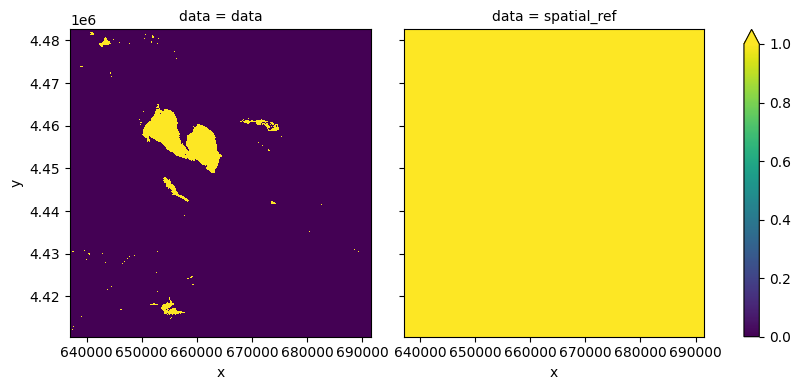

In [25]:
_ = (
    water_bodies.isel(time=0)
    .to_array("data")
    .plot.imshow(
        col="data",
        size=4,
        vmin=0,
        vmax=1,
    )
)